In [1]:
from analysis_tools import Dataset, Process, Feature
from pprint import pprint
import ROOT
ROOT.ROOT.EnableImplicitMT()

Welcome to JupyROOT 6.18/04


In [2]:
ggf_sm_process = Process("ggf_sm", "GGFSM", color=(0, 0, 0))
ggf_bis = Dataset("ggf_sm_bis",
             "/eos/user/j/jleonhol/HH/htautau_ggf/",
             ggf_sm_process)


files = ggf_bis.get_files()[0:1]
print files
#files = ["/eos/user/j/jleonhol/HH/htautau_ggf/NANO_NANO_188.root"]
dataframe_files = ROOT.vector(str)()
for f in files:
    dataframe_files.push_back(f)
new_df = ROOT.RDataFrame("Events", dataframe_files)



f = ROOT.TFile.Open(files[0])


['/eos/user/j/jleonhol/HH/htautau_ggf//NANO_NANO_1.root']


In [18]:
data_pro = Process("data", "data", color=(0, 0, 0))
data = Dataset("data",
             "/eos/home-j/jleonhol/HH/run322599",
             data_pro)


files = data.get_files()
print files
#files = ["/eos/user/j/jleonhol/HH/htautau_ggf/NANO_NANO_188.root"]
dataframe_files = ROOT.vector(str)()
for f in files:
    dataframe_files.push_back(f)
new_df = ROOT.RDataFrame("l1UpgradeTree/L1UpgradeTree", dataframe_files)
#new_df = ROOT.RDataFrame("l1EventTree/L1EventTree", dataframe_files)




['/eos/home-j/jleonhol/HH/run322599/L1Ntuple_1.root', '/eos/home-j/jleonhol/HH/run322599/L1Ntuple_10.root', '/eos/home-j/jleonhol/HH/run322599/L1Ntuple_100.root', '/eos/home-j/jleonhol/HH/run322599/L1Ntuple_101.root', '/eos/home-j/jleonhol/HH/run322599/L1Ntuple_11.root', '/eos/home-j/jleonhol/HH/run322599/L1Ntuple_12.root', '/eos/home-j/jleonhol/HH/run322599/L1Ntuple_13.root', '/eos/home-j/jleonhol/HH/run322599/L1Ntuple_14.root', '/eos/home-j/jleonhol/HH/run322599/L1Ntuple_15.root', '/eos/home-j/jleonhol/HH/run322599/L1Ntuple_16.root', '/eos/home-j/jleonhol/HH/run322599/L1Ntuple_17.root', '/eos/home-j/jleonhol/HH/run322599/L1Ntuple_18.root', '/eos/home-j/jleonhol/HH/run322599/L1Ntuple_19.root', '/eos/home-j/jleonhol/HH/run322599/L1Ntuple_2.root', '/eos/home-j/jleonhol/HH/run322599/L1Ntuple_20.root', '/eos/home-j/jleonhol/HH/run322599/L1Ntuple_21.root', '/eos/home-j/jleonhol/HH/run322599/L1Ntuple_22.root', '/eos/home-j/jleonhol/HH/run322599/L1Ntuple_23.root', '/eos/home-j/jleonhol/HH/ru

In [19]:
histo = new_df.Histo1D("tauEt")

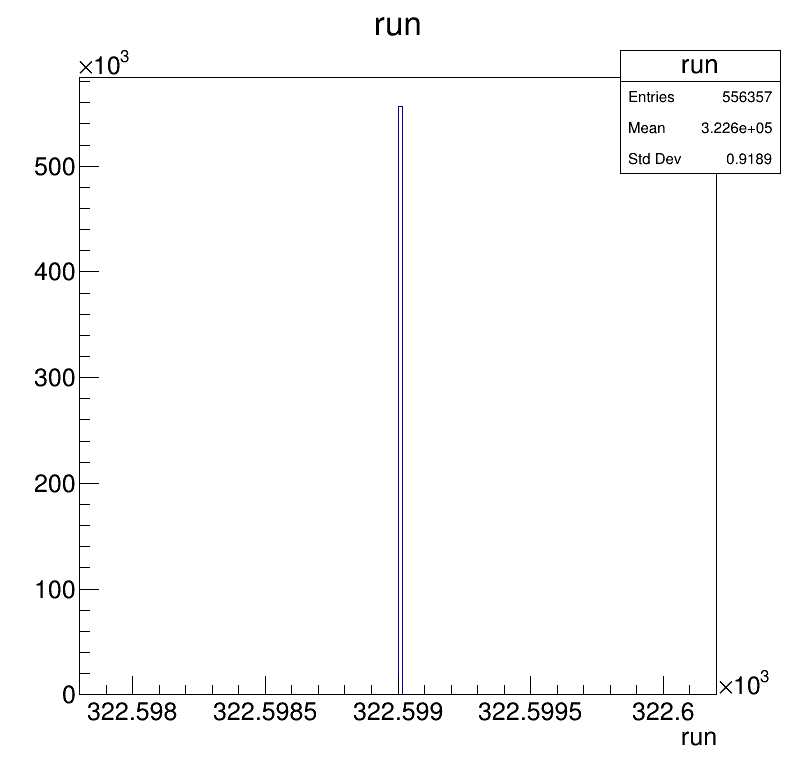

In [15]:
c = ROOT.TCanvas("", "", 800, 800)
histo.Draw()
c.Draw()

In [3]:
def add_to_root(root):
    root.gInterpreter.Declare("""
        using Vfloat = const ROOT::RVec<float>&;      
        ROOT::RVec<ROOT::RVec<float>> lead_sublead(Vfloat pt, Vfloat eta, Vfloat phi, Vfloat mass){
            ROOT::RVec<float> leading_pts = {-1., -1.};
            ROOT::RVec<float> leading_etas = {-1., -1.};
            ROOT::RVec<float> leading_phis = {-1., -1.};
            ROOT::RVec<float> leading_mass = {-1., -1.};
            for (size_t i = 0; i < pt.size(); i++) {
                if (pt[i] > leading_pts[0]){
                    leading_pts[1] = leading_pts[0];
                    leading_etas[1] = leading_etas[0];
                    leading_phis[1] = leading_phis[0];
                    leading_mass[1] = leading_mass[0];
    
                    leading_pts[0] = pt[i];
                    leading_etas[0] = eta[i];
                    leading_phis[0] = phi[i];
                    leading_mass[0] = mass[i];
                } 
                else if (pt[i] > leading_pts[1]){
                    leading_pts[1] = pt[i];
                    leading_etas[1] = eta[i];
                    leading_phis[1] = phi[i];
                    leading_mass[1] = mass[i];
                }
            }
            return ROOT::RVec({leading_pts, leading_etas, leading_phis, leading_mass});
        }
    """)
    root.gInterpreter.Declare("""
    #include <TLorentzVector.h>
    using Vfloat = const ROOT::RVec<float>&;      
    ROOT::RVec<bool> maskDeltaR(Vfloat pt1, Vfloat eta1, Vfloat phi1, Vfloat mass1, Vfloat pt2, Vfloat eta2, Vfloat phi2, Vfloat mass2, float th_dr) {
        ROOT::RVec<bool> mask;
        for (size_t i = 0; i < pt1.size(); i++){
            TLorentzVector v1;
            v1.SetPtEtaPhiM(pt1[i], eta1[i], phi1[i], mass1[i]);
            int bigger_deltar = true;
            for (size_t j = 0; j < pt2.size(); j++){
                TLorentzVector v2;
                v2.SetPtEtaPhiM(pt2[j], eta2[j], phi2[j], mass2[j]);
                float this_deltar = fabs(v1.DeltaR(v2));
                if (abs(this_deltar) < th_dr) bigger_deltar = false;
            }
            mask.push_back(bigger_deltar);
        }
        return mask;
    }
""")
    return root
ROOT = add_to_root(ROOT)

In [4]:
new_df = (new_df.Define("lead_sublead_goodtau_pt",
    "lead_sublead("
        "Tau_pt[abs(Tau_eta) <= 2.1], "
        "Tau_eta[abs(Tau_eta) <= 2.1], "
        "Tau_phi[abs(Tau_eta) <= 2.1], "
        "Tau_mass[abs(Tau_eta) <= 2.1]"
    ")[0]").Define("lead_sublead_goodtau_eta", 
    "lead_sublead("
        "Tau_pt[abs(Tau_eta) <= 2.1], "
        "Tau_eta[abs(Tau_eta) <= 2.1], "
        "Tau_phi[abs(Tau_eta) <= 2.1], "
        "Tau_mass[abs(Tau_eta) <= 2.1]"
    ")[1]").Define("lead_sublead_goodtau_phi", 
    "lead_sublead("
        "Tau_pt[abs(Tau_eta) <= 2.1], "
        "Tau_eta[abs(Tau_eta) <= 2.1], "
        "Tau_phi[abs(Tau_eta) <= 2.1], "
        "Tau_mass[abs(Tau_eta) <= 2.1]"
    ")[2]").Define("lead_sublead_goodtau_mass", 
    "lead_sublead("
        "Tau_pt[abs(Tau_eta) <= 2.1], "
        "Tau_eta[abs(Tau_eta) <= 2.1], "
        "Tau_phi[abs(Tau_eta) <= 2.1], "
        "Tau_mass[abs(Tau_eta) <= 2.1]"
    ")[3]"))

In [5]:
new_df = new_df.Define("lead_sublead_goodl1tau_pt",
    "lead_sublead("
        "L1Obj_pt[L1Obj_type == 1 && L1Obj_iso == 1 && abs(L1Obj_eta) <= 2.1], "
        "L1Obj_eta[L1Obj_type == 1 && L1Obj_iso == 1 && abs(L1Obj_eta) <= 2.1], "
        "L1Obj_phi[L1Obj_type == 1 && L1Obj_iso == 1 && abs(L1Obj_eta) <= 2.1], "
        "L1Obj_pt[L1Obj_type == 1 && L1Obj_iso == 1 && abs(L1Obj_eta) <= 2.1]"
    ")[0]").Define("lead_sublead_goodl1tau_eta", 
    "lead_sublead("
        "L1Obj_pt[L1Obj_type == 1 && L1Obj_iso == 1 && abs(L1Obj_eta) <= 2.1], "
        "L1Obj_eta[L1Obj_type == 1 && L1Obj_iso == 1 && abs(L1Obj_eta) <= 2.1], "
        "L1Obj_phi[L1Obj_type == 1 && L1Obj_iso == 1 && abs(L1Obj_eta) <= 2.1], "
        "L1Obj_pt[L1Obj_type == 1 && L1Obj_iso == 1 && abs(L1Obj_eta) <= 2.1]"
    ")[1]").Define("lead_sublead_goodl1tau_phi", 
    "lead_sublead("
        "L1Obj_pt[L1Obj_type == 1 && L1Obj_iso == 1 && abs(L1Obj_eta) <= 4.7], "
        "L1Obj_eta[L1Obj_type == 1 && L1Obj_iso == 1 && abs(L1Obj_eta) <= 4.7], "
        "L1Obj_phi[L1Obj_type == 1 && L1Obj_iso == 1 && abs(L1Obj_eta) <= 4.7], "
        "L1Obj_pt[L1Obj_type == 1 && L1Obj_iso == 1 && abs(L1Obj_eta) <= 4.7]"
    ")[2]")

In [15]:
hmodel = ("pt", "; L1 Jet pt; Events / 4 GeV", 35, 20, 160)
pt = new_df.Define(
    "L1GoodJetPt",
    "L1Obj_pt["
        "L1Obj_type == 0 "
        "&& abs(L1Obj_eta) < 4.7"
        "&& maskDeltaR("
            "L1Obj_pt, "
            "L1Obj_eta, "
            "L1Obj_phi, "
            "L1Obj_pt, "
            "lead_sublead_goodl1tau_pt, "
            "lead_sublead_goodl1tau_eta, "
            "lead_sublead_goodl1tau_phi, "
            "lead_sublead_goodl1tau_pt, "
            "0.5)"
    "]"
).Define(
    "L1LeadingJetPt",
    "lead_sublead(L1GoodJetPt, L1GoodJetPt, L1GoodJetPt, L1GoodJetPt)[0][0]"
).Histo1D(hmodel, "L1LeadingJetPt")



In [17]:
f_df = new_df.Filter("lead_sublead_goodl1tau_pt[1] > 26")

In [18]:
pt = f_df.Define(
    "L1GoodJetPt",
    "L1Obj_pt["
        "L1Obj_type == 0 "
        "&& abs(L1Obj_eta) < 4.7"
        "&& maskDeltaR("
            "L1Obj_pt, "
            "L1Obj_eta, "
            "L1Obj_phi, "
            "L1Obj_pt, "
            "lead_sublead_goodl1tau_pt, "
            "lead_sublead_goodl1tau_eta, "
            "lead_sublead_goodl1tau_phi, "
            "lead_sublead_goodl1tau_pt, "
            "0.5)"
    "]"
).Define(
    "L1LeadingJetPt",
    "lead_sublead(L1GoodJetPt, L1GoodJetPt, L1GoodJetPt, L1GoodJetPt)[0][0]"
).Histo1D(hmodel, "L1LeadingJetPt")

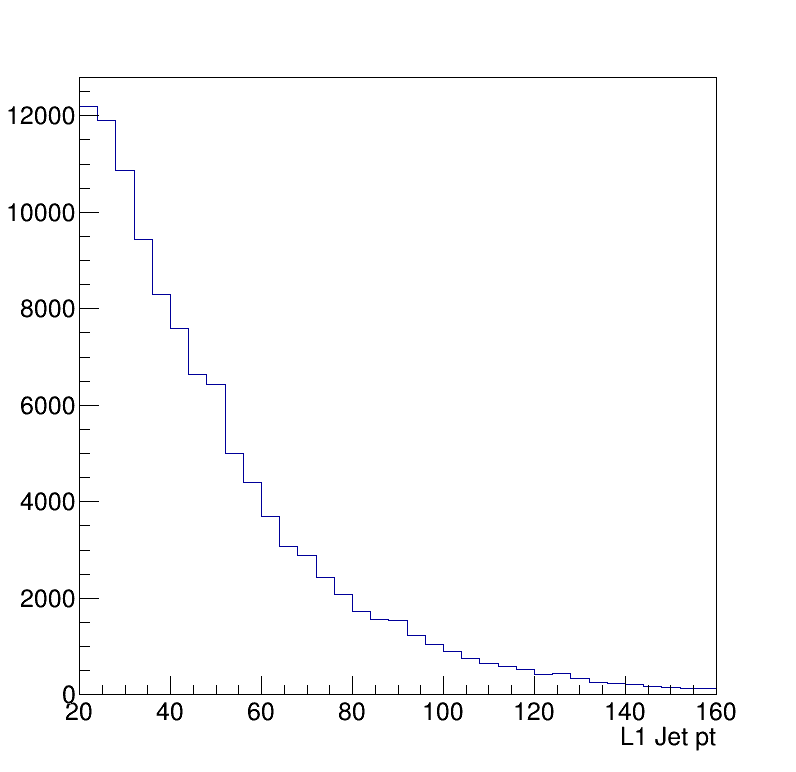

In [19]:
ROOT.gStyle.SetOptStat(0)
c = ROOT.TCanvas("", "", 800, 800)
h = pt.Clone()
#h.Scale(1./h.GetEntries())
#h.GetXaxis().SetRangeUser(0, 200)
h.Draw()
c.Draw()

## Compute the jet probability for YY = 26, 34 

In [35]:
(xx, yy, zz)= (34, 26, 64)
df_26 = new_df.Filter(
    "lead_sublead_goodtau_pt[0] >= (26 + 18) "
    "&& lead_sublead_goodtau_pt[1] >= (26 + 8)"
    "&& (Jet_pt["
            "(Jet_pt >= (20 + 10)) && abs(Jet_eta) <= 4.7 && Jet_jetId >= 2 "
            "&& ((Jet_puId >= 4 && Jet_pt <= 50) || (Jet_pt > 50))"
            "&& maskDeltaR("
                "Jet_pt, "
                "Jet_eta, "
                "Jet_phi, "
                "Jet_pt, "
                "lead_sublead_goodtau_pt, "
                "lead_sublead_goodtau_eta, "
                "lead_sublead_goodtau_phi, "
                "lead_sublead_goodtau_mass, "
                "0.5)"
     "].size() >= 2)"
     "&& (Jet_pt["
            "(Jet_pt >= (20 + 10)) && abs(Jet_eta) <= 4.7 && Jet_jetId >= 2 "
            "&& ((Jet_puId >= 4 && Jet_pt <= 50) || (Jet_pt > 50))"
            "&& maskDeltaR("
                "Jet_pt, "
                "Jet_eta, "
                "Jet_phi, "
                "Jet_pt, "
                "lead_sublead_goodtau_pt, "
                "lead_sublead_goodtau_eta, "
                "lead_sublead_goodtau_phi, "
                "lead_sublead_goodtau_mass, "
                "0.5)"
      "].size() <= 999)"
)
df_34 = new_df.Filter(
    "lead_sublead_goodtau_pt[0] >= (34 + 18) "
    "&& lead_sublead_goodtau_pt[1] >= (34 + 8)"
    "&& (Jet_pt["
            "(Jet_pt >= (20 + 10)) && abs(Jet_eta) <= 4.7 && Jet_jetId >= 2 "
            "&& ((Jet_puId >= 4 && Jet_pt <= 50) || (Jet_pt > 50))"
            "&& maskDeltaR("
                "Jet_pt, "
                "Jet_eta, "
                "Jet_phi, "
                "Jet_pt, "
                "lead_sublead_goodtau_pt, "
                "lead_sublead_goodtau_eta, "
                "lead_sublead_goodtau_phi, "
                "lead_sublead_goodtau_mass, "
                "0.5)"
     "].size() >= 2)"
     "&& (Jet_pt["
            "(Jet_pt >= (20 + 10)) && abs(Jet_eta) <= 4.7 && Jet_jetId >= 2 "
            "&& ((Jet_puId >= 4 && Jet_pt <= 50) || (Jet_pt > 50))"
            "&& maskDeltaR("
                "Jet_pt, "
                "Jet_eta, "
                "Jet_phi, "
                "Jet_pt, "
                "lead_sublead_goodtau_pt, "
                "lead_sublead_goodtau_eta, "
                "lead_sublead_goodtau_phi, "
                "lead_sublead_goodtau_mass, "
                "0.5)"
      "].size() <= 999)"
)

In [36]:
pass_histos26 = {}
pass_histos34 = {}
for zz in range(20, 160):
    hmodel = ("passhisto26_" + str(zz), "", 2, 0, 2)
    pass_histos26[zz] = df_26.Define("pass_jet" + str(zz),
        # ask for at least 1 jet with pt > zz (+ sth depending on the dataset)
        "Jet_pt["
            "(Jet_pt >= ({0} + 10)) && abs(Jet_eta) <= 4.7 && Jet_jetId >= 2 "
            "&& ((Jet_puId >= 4 && Jet_pt <= 50) || (Jet_pt > 50))"
            "&& maskDeltaR("
                "Jet_pt, "
                "Jet_eta, "
                "Jet_phi, "
                "Jet_pt, " # dum, not needed for deltaR, just for LV
                "lead_sublead_goodtau_pt, "
                "lead_sublead_goodtau_eta, "
                "lead_sublead_goodtau_phi, "
                "lead_sublead_goodtau_mass, "
                "0.5)"
            "].size() >= 1".format(zz)
        ).Histo1D(hmodel, "pass_jet" + str(zz))
    hmodel = ("passhisto34_" + str(zz), "", 2, 0, 2)
    pass_histos34[zz] = df_34.Define("pass_jet" + str(zz),
        # ask for at least 1 jet with pt > zz (+ sth depending on the dataset)
        "Jet_pt["
            "(Jet_pt >= ({0} + 10)) && abs(Jet_eta) <= 4.7 && Jet_jetId >= 2 "
            "&& ((Jet_puId >= 4 && Jet_pt <= 50) || (Jet_pt > 50))"
            "&& maskDeltaR("
                "Jet_pt, "
                "Jet_eta, "
                "Jet_phi, "
                "Jet_pt, " # dum, not needed for deltaR, just for LV
                "lead_sublead_goodtau_pt, "
                "lead_sublead_goodtau_eta, "
                "lead_sublead_goodtau_phi, "
                "lead_sublead_goodtau_mass, "
                "0.5)"
            "].size() >= 1".format(zz)
        ).Histo1D(hmodel, "pass_jet" + str(zz))

In [37]:
passhisto2D26 = ROOT.TH2F("passhisto2D26", "", 140, 20, 160, 2, 0, 2)
passhisto2D34 = ROOT.TH2F("passhisto2D34", "", 140, 20, 160, 2, 0, 2)
for zz in range(20, 160):
    for bin in range(0, 2):
        passhisto2D26.SetBinContent(zz - 20 + 1, bin + 1, pass_histos26[zz].GetBinContent(bin + 1))
        passhisto2D34.SetBinContent(zz - 20 + 1, bin + 1, pass_histos34[zz].GetBinContent(bin + 1))

In [38]:
histo_pass26 = ROOT.TH1F("histo_pass26", "", 140, 20, 160)
histo_pass34 = ROOT.TH1F("histo_pass34", "", 140, 20, 160)
for zz in range(20, 160):
    num = sum([passhisto2D26.GetBinContent(zz - 20 + 1, bin + 1) * bin for bin in range(0, 2)])
    den = sum([passhisto2D26.GetBinContent(zz - 20 + 1, bin + 1)       for bin in range(0, 2)])
    histo_pass26.SetBinContent(zz - 20 + 1,  0 if den == 0 else num / den)
    
    num = sum([passhisto2D34.GetBinContent(zz - 20 + 1, bin + 1) * bin for bin in range(0, 2)])
    den = sum([passhisto2D34.GetBinContent(zz - 20 + 1, bin + 1)       for bin in range(0, 2)])
    histo_pass34.SetBinContent(zz - 20 + 1,  0 if den == 0 else num / den)

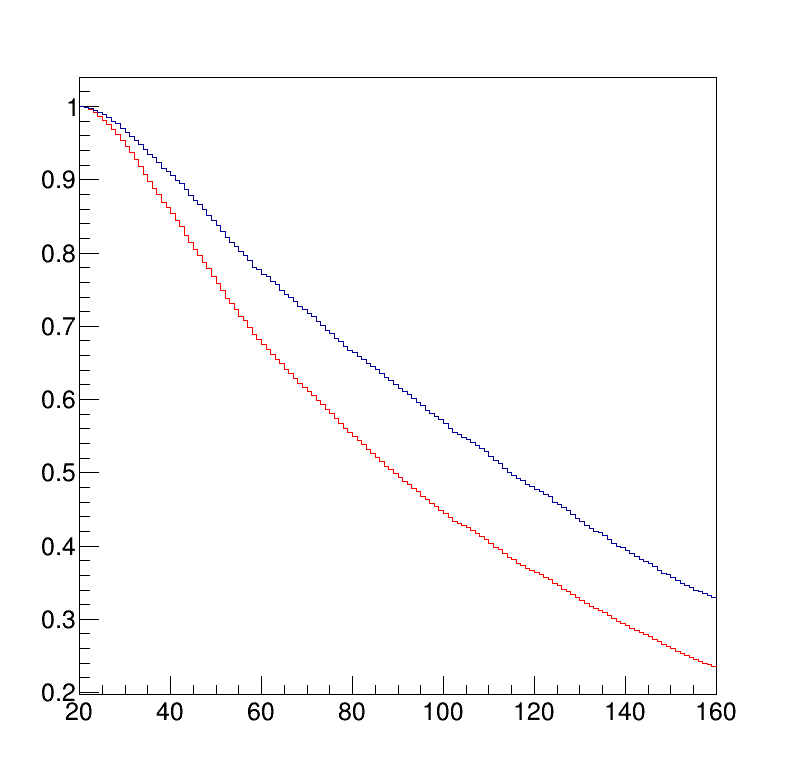

In [39]:
ROOT.gStyle.SetOptStat(0)
c = ROOT.TCanvas("", "", 800, 800)
h1 = histo_pass26.Clone()
h2 = histo_pass34.Clone()

h1.SetLineColor(ROOT.kRed)

h1.Draw()
h2.Draw("same")
c.Draw()

## Trying to reproduce the trigger requirements by hand

In [6]:
xx = 34
yy = 26
zz = 64

name = "DoubleIsoTau{}er2p1".format(xx)
new_df = new_df.Define(name, 
    "L1Obj_pt["
        "L1Obj_type == 1 "
        "&& abs(L1Obj_eta) <= 2.1 "
        "&& L1Obj_iso == 1 "
        "&& L1Obj_pt >= {}"
    "].size() >= 2".format(xx)
)
name = "DoubleIsoTau{}er2p1Jet{}dR0p5".format(yy, zz)
new_df = new_df.Define(name,
    "lead_sublead_goodl1tau_pt[0] >= {0} "
    "&& lead_sublead_goodl1tau_pt[1] >= {0}"
    "&& (L1Obj_pt["
        "L1Obj_type == 0 "
        "&& L1Obj_pt >= {1} "
        "&& maskDeltaR("
            "L1Obj_pt, "
            "L1Obj_eta, "
            "L1Obj_phi, "
            "L1Obj_pt, " # dum, not needed for deltaR, just for TLorentzVector
            "lead_sublead_goodl1tau_pt, "
            "lead_sublead_goodl1tau_eta, "
            "lead_sublead_goodl1tau_phi, "
            "lead_sublead_goodl1tau_pt, " # dum
            "0.5)"
        "].size() >= 1)".format(yy, zz))

NameError: name 'df' is not defined

In [45]:
name = "RecoDoubleIsoTau{}er2p1".format(xx)
new_df = new_df.Define(name, 
    "lead_sublead_goodtau_pt[0] >= ({0} + {1}) "
    "&& lead_sublead_goodtau_pt[1] >= ({0} + {2})".format(
        xx, 
        18,
        8
    )
)

In [65]:
l1_events = 0
reco_events = 0
and_events = 0
total_events = 0
for event in f.Events:
    total_events += 1
    
    # start storing the 4-vectors for the leading and subleading taus
    # these are used only in the future to compute the deltaR between the taus and jets
    # so we only need eta and phi. pt and mass are stored just to build the TLorentzVector
    # note: as L1 does not compute the object's mass, we fill its spot with the pt as a dummy value, 
    # as it won't be needed
    leading_l1_tau = [-1., -1., -1., -1.]
    subleading_l1_tau = [-1., -1., -1., -1.]
    for L1Obj in zip(event.L1Obj_pt, event.L1Obj_type, event.L1Obj_eta, event.L1Obj_phi, event.L1Obj_iso):
        if L1Obj[1] != 1: continue # skip if it's not a tau
        if abs(L1Obj[2]) > 2.1: continue # skip if the L1 tau doesn't pass the eta req
        if L1Obj[4] != 1: continue # skip if the L1 tau is not isolated

        if L1Obj[0] > leading_l1_tau[0]:
            subleading_l1_tau = [leading_l1_tau[0], leading_l1_tau[1], leading_l1_tau[2], leading_l1_tau[3]]
            leading_l1_tau = [L1Obj[0], L1Obj[2], L1Obj[3], L1Obj[0]]
        elif L1Obj[0] > subleading_l1_tau[0]:
            subleading_l1_tau = [L1Obj[0], L1Obj[2], L1Obj[3], L1Obj[0]]

    if leading_l1_tau[0] >= xx and subleading_l1_tau[0] >= xx: l1_events += 1
        
    leading_tau = [-1., -1., -1., -1.]
    subleading_tau = [-1., -1., -1., -1.]
    for tau in zip(event.Tau_pt, event.Tau_eta, event.Tau_phi, event.Tau_mass):
        if abs(tau[1]) > 2.1: continue
        if tau[0] > leading_tau[0]:
            subleading_tau = [leading_tau[0], leading_tau[1], leading_tau[2], leading_tau[3]]
            leading_tau = [tau[0], tau[1], tau[2], tau[3]]
        elif tau[0] > subleading_tau[0]:
            subleading_tau = [tau[0], tau[1], tau[2], tau[3]]
    if leading_tau[0] >= xx + 18 and subleading_tau[0] >= xx + 8:
        reco_events += 1
        if leading_l1_tau[0] >= xx and subleading_l1_tau[0] >= xx:
            and_events += 1

In [66]:
print l1_events, reco_events, and_events, total_events

8497 1943 1395 80000


In [51]:
hmodel = ("histo32", "", 2, 0, 2)
histo = new_df.Define("pass", "DoubleIsoTau32er2p1").Histo1D(hmodel, "pass")
histoReco = new_df.Define("pass", "RecoDoubleIsoTau32er2p1").Histo1D(hmodel, "pass")
histoAND = new_df.Define("pass", "DoubleIsoTau32er2p1 && RecoDoubleIsoTau32er2p1").Histo1D(hmodel, "pass")

In [52]:
c = ROOT.TCanvas("", "", 800, 800)
h = histo.Clone()
h.Draw()
#c.Draw()
print histo.GetBinContent(2)
print histoReco.GetBinContent(2)
print histoAND.GetBinContent(2)

8497.0
1943.0
1395.0
